In [1]:
from plot_classes import *

In [2]:
class RatioPlot(Hist1D):
    
    
    def __init__(self, samples=[], reference: str =None, data=[], errors: str =None, stack=False, **kwargs) -> None:
        
        super().__init__(samples=samples, data=data, errors=errors, stack=stack, layout=(2,1), **kwargs)
        self.check_input
        
        self.reference = reference
        
        self.numerators = {}
        self.denominator = {}
        self.dvals = []
        
        self.check_reference()
        self.ratiovalues_calculator()
        
        # default variables
        self.spacing = 0
        self.stretch = 4
            
        # bool if user put a custom y limits for bot plot
        self.custom_ylims = False
        
        
    """
    -----------------------------------------------------------------------------------------------------
    Private functions
    -----------------------------------------------------------------------------------------------------
    """ 
    
    def check_reference(self) -> None:
        
        if self.reference:
            if self.reference in self.samples:
                for samplename, sample in self.samples_dict.items():
                    if samplename == self.reference:
                        self.denominator[samplename] = sample
                        self.dvals = list(next(iter(self.denominator.values())).values())
                    else:
                        self.numerators[samplename] = sample
            elif self.reference == 'total':
                if self.data and len(self.data) == 1:
                    self.numerators = self.data_dict
                    self.dvals = self.get_stackvalues(self.histos_list)
                else:
                    logging.error("Please specify one (and only one) sample that will be plotted as data using the 'data' argument")
            else:
                logging.error("Selected reference is not in 'samples'")
        else:
            logging.error("Specify a reference sample which will act as the denominator for the ratio plot")
    
    
    def ratiovalues_calculator(self) -> None:
        """ Calculate and store ratio values of specified samples (numerators) """
        
        self.ratiovalues = {}
        for samplename, sample in self.numerators.items():
            self.ratiovalues[samplename] = []
            for n, m in zip(sample.values(), self.dvals):
                if m != 0:
                    self.ratiovalues[samplename].append(n/m)
                else:
                    self.ratiovalues[samplename].append(0)
    
    
    def ratio_scatters(self, samplename: str, color: str) -> None:
        """ Used when need to plot ratio values in bot plot as scatter points """

        hep.histplot(
            # np.ones(len(self.ratiovalues[samplename])),
            self.ratiovalues[samplename],
            bins=self.edges,
            ax=self.botax,
            yerr=False, 
            histtype='errorbar',
            color=color,
            marker=self.rcps['lines.marker'],
            markersize=self.rcps['lines.markersize'],
        )
        
    
    def ratio_histbins(self, samplename: str, color: str) -> None:
        """ Used when need to plot ratio values in bot plot as hist bins """
        print(color)

        if self.shape == 'hollow':
            self.botax.stairs(
                self.ratiovalues[samplename], 
                self.edges, 
                baseline=1,
                color=color,
                fill=False,
                linewidth=self.rcps['lines.linewidth'],
            )
        
        else:            
            self.botax.stairs(
                self.ratiovalues[samplename], 
                self.edges, 
                baseline=1,
                edgecolor='black',
                facecolor=color,
                fill=True,
                linewidth=self.rcps['lines.linewidth'],
            )
        
        
    def custom_yaxis(self, ylims: list, step: float =None, edges=False) -> None:
        """
        Allow user to manually change the bot y axis limits, which can often
        overlap with various other plot elements. If edges is set to True,
        the first and last ticks will be shown in the plot.
        """
        
        if step is None:
            # do something
            step = step
        
        self.custom_ylims = True
        
        self.ylims = ylims
        self.ystep = step
        self.ybotrange = np.arange(ylims[0], ylims[-1]+step, step)
        
        # check if any tick label would have non zero decimal places,
        # if so, leave zeros for all other tick labels as well
        # if not, remove all decimal zeros from tick labels
        temprange = [f'{x:.2f}' for x in self.ybotrange]
        need1 = False
        need2 = False
        
        for num in temprange[1:-1]:
            decimals = num.split('.')[1]
            d1 = decimals[0]
            d2 = decimals[1]
            
            if d2 != '0':
                need2 = True
                break
            if d1 != '0':
                need1 = True
        if need2:
            self.ybotlabels = [f'{x:.2f}' for x in self.ybotrange]
        elif need1:
            self.ybotlabels = [f'{x:.1f}' for x in self.ybotrange]
        else:
            self.ybotlabels = [f'{x:.0f}' for x in self.ybotrange]            
        
        if not edges:
            self.ybotlabels[0] = ''
            self.ybotlabels[-1] = ''
    
    
    def main_plot(self) -> None:
        
        self.hist_plot(self.mainax)
        
        # set x axis ticks
        self.mainax.set_xticks(np.linspace(self.edges[0], self.edges[-1], 11))
        self.mainax.set_xticklabels([]) # suppress x tick labels
    
    
    def bot_plot(self) -> None:
                    
        _notused, _clist = self.get_samples_colors(self.numerators)
        if type(_clist) != list:
            _clist = [_clist]

        # iterate through all samples in self.numerators along with corresponding color
        for i, samplename in enumerate(self.numerators.keys()):
            if samplename in self.data or self.data == 'all':
                self.ratio_scatters(samplename, _clist[i])
            else:
                self.ratio_histbins(samplename, _clist[i])
        
        # plot error histograms
        if self.errors == 'hist' or self.errors == 'all':
            self.histbins_errs(self.botax, ratio=True)
            
        # set tick params
        self.set_tickparams(self.botax, self.rcps['font.size'])
        
        # set x ticks
        self.botax.set_xticks(np.linspace(self.edges[0], self.edges[-1], 11))
        
        # set x and y axis labels
        self.set_xtitles(self.botax, 'xbot', self.fontsize)
        if self.ytitles_dict['ybot']:
            self.set_ytitles(self.botax, 'ybot', self.fontsize)
        else:
            self.botax.set_ylabel(f"Ratio against \n{self.reference}", fontsize=self.fontsize)
        
        # draw horizontal line at y=1
        self.botax.axhline(1, -1, 2, color='k', linestyle='--', linewidth=0.7)

        # in case there is custom y lims
        if self.custom_ylims:
            self.botax.set_ylim(self.ylims)
            self.botax.set_yticks(self.ybotrange)
            self.botax.set_yticklabels(self.ybotlabels, fontsize=self.rcps['font.size'])
        
        # put grid if requested
        if self.need_grid:
            self.botax.grid(axis=self.gridaxis, linestyle=self.gridline, alpha=0.3, color='k')
        
    
    def ratio_plot(self) -> None:
        
        # main plot
        self.main_plot()

        # ratio plot
        self.bot_plot()

        
    """
    -----------------------------------------------------------------------------------------------------
    Public functions
    -----------------------------------------------------------------------------------------------------
    """ 

    
    def ratio_options(self, ylims=[], step: float =None, edges=False) -> None:
        
        self.custom_yaxis(ylims, step, edges)
    
    
    def figure_options(self, spacing: float =None, stretch: int =None, **figkw) -> None:
        
        super().figure_options(**figkw)
        if spacing:
            self.spacing = spacing
        if stretch:
            self.stretch = stretch

    
    def create(self, save_name='', dpi=1000) -> None:
        
        # create plot figure and subplots
        self.create_canvas()
        self.make_grid(hspace=self.spacing, height_ratios=[self.stretch,1])
        self.mainax = self.make_subplot(0, 1, 0, 1)
        self.botax  = self.make_subplot(1, 2, 0, 1)
        
        # make plot
        self.ratio_plot()
        
        if save_name:
            self.saveimage(save_name, dpi)

            
        # b1 = self.botax.get_tightbbox(self.botax.figure.canvas.renderer)
#         b = self.botax.yaxis.get_tightbbox(self.botax.figure.canvas.renderer)

#         def show_bbox_edges(ax, bbox):
#             points = bbox.get_points().tolist()
#             x = [points[0][0], points[1][0]]
#             y = [points[0][1], points[1][1]]
#             print(x, y)
#             ax.scatter(x, y, color='blue', marker='+')

#         show_bbox_edges(self.botax, b)
        for text in self.botax.yaxis.get_ticklabels():
            textbbox = text.get_window_extent().transformed(self.botax.transAxes.inverted())
            points = textbbox.get_points().tolist()
            print(text, points)
            # x = [points[0][0], points[1][0]]
            # y = [points[0][1], points[1][1]]
            # self.botax.scatter(x, y, color='blue', marker='+')

Text(0, 0.0, '$\\mathdefault{0}$') [[-0.025206575246132207, -0.09837662337662334], [-0.008790436005625901, 0.06558441558441563]]
Text(0, 1.0, '$\\mathdefault{1}$') [[-0.021137859152099675, 0.5682900432900435], [-0.008790436005625901, 0.7322510822510824]]
Text(0, 0, '') [[-0.008790436005625901, 0.0], [-0.008790436005625901, 0.0]]
Text(0, 0, '') [[-0.008790436005625901, 0.0], [-0.008790436005625901, 0.0]]


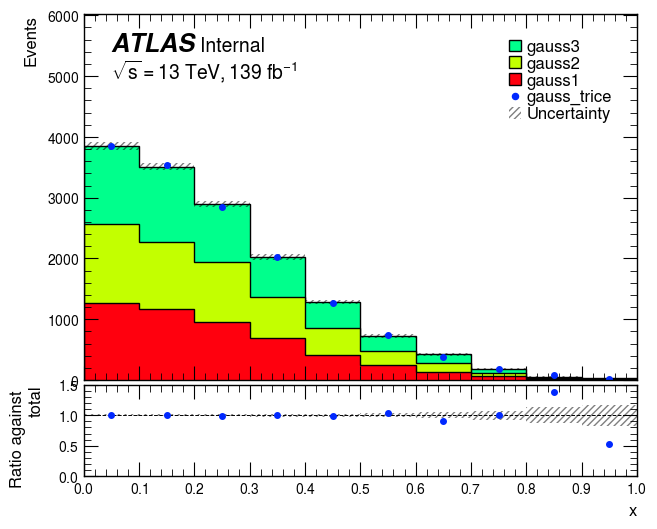

In [6]:
rplot = RatioPlot(
    samples=['gauss1', 'gauss2', 'gauss3', 'gauss_trice'], 
    data='gauss_trice',
    reference='total',
    stack=True,
    errors='hist',
    directory='/afs/cern.ch/user/f/flciciri/public/Pythium/plotting_misc/pickle_files/'
)
# rplot.color_options(reverse=True)
rplot.figure_options(spacing=0.02, figsize=(7,6))
# rplot.ratio_options([0.5,1.5], 0.3)
# rplot.plot_options(shape='hollow', gridstring='y:')
rplot.set_axislabels(12, ymain="Events", xbot=rplot.names[0])
# rplot.fontsize_options(labels=20)
rplot.create()
# rplot.saveimage("RatioPlot_demo", 1000)

In [4]:
rplot.botax.yaxis.get_ticklabels()[0].get_window_extent()

Bbox([[44.1600341796875, 47.0], [59.5, 59.0]])

In [5]:
# rplot.botax.xaxis.get_window_extent(rplot.botax.figure.canvas.renderer)
rplot.botax.yaxis.get_ticklabel_extents(rplot.botax.figure.canvas.renderer)

(Bbox([[44.0350341796875, 47.0], [59.6, 123.5861386138614]]),
 Bbox([[0.0, 0.0], [0.0, 0.0]]))